In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load the dataset

In [151]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

# Data Exploration

In [200]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.00000,1,0,A/5 21171,7.2500,NaN,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.00000,1,0,PC 17599,71.2833,C85,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.00000,0,0,STON/O2. 3101282,7.9250,NaN,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.00000,1,0,113803,53.1000,C123,2
4,5,0,3,"Allen, Mr. William Henry",1,35.00000,0,0,373450,8.0500,NaN,2
5,6,0,3,"Moran, Mr. James",1,25.14062,0,0,330877,8.4583,NaN,1
6,7,0,1,"McCarthy, Mr. Timothy J",1,54.00000,0,0,17463,51.8625,E46,2
7,8,0,3,"Palsson, Master. Gosta Leonard",1,2.00000,3,1,349909,21.0750,NaN,2
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,27.00000,0,2,347742,11.1333,NaN,2
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",0,14.00000,1,0,237736,30.0708,NaN,0


In [152]:
train.apply(lambda x: sum(x.isnull()),axis=0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Impute missing values

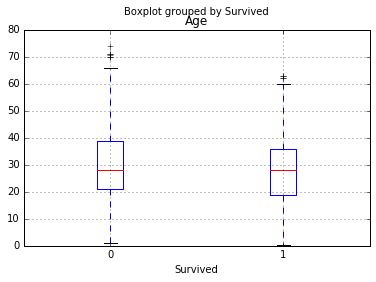

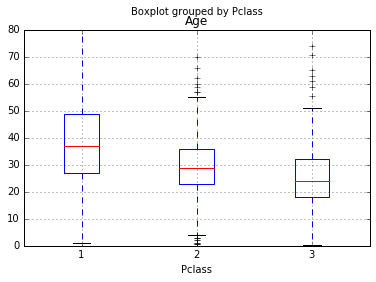

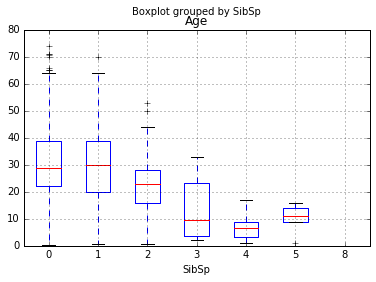

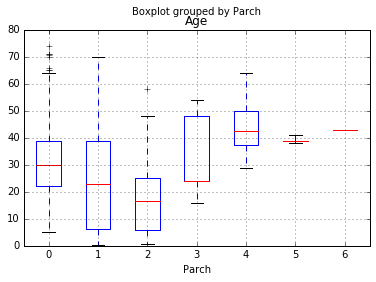

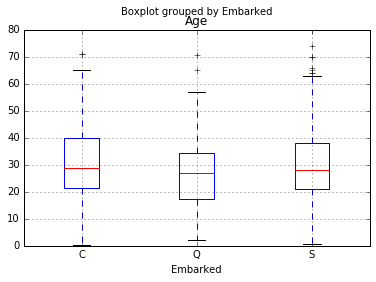

In [153]:
#cols=list(train.columns)
#cols.remove(['Age','PassengerId','Name','Ticket','Fare','Cabin'])
cols=['Survived','Pclass','SibSp','Parch','Embarked']
for col in cols:
    train.boxplot('Age',by=col)

<b> It seems there is a relation between the Age group of the passangers and the pclass. SO I think, it would be good idea to impute it with the mean of each pclass.</b>

In [154]:
import math
age_pclass_pivot=train.pivot_table(values='Age',index='Pclass',aggfunc=lambda x:x.mean())
def fillna_Age (x):
    return age_pclass_pivot.loc[x['Pclass']]
age_pclass_pivot
train['Age'].fillna(train[train['Age'].isnull()].apply(fillna_Age,axis=1),inplace=True)

In [155]:
train['Embarked'].fillna('S',inplace=True)

In [156]:
train.apply(lambda x: sum(x.isnull()),axis=0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

# Building Model

In [157]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import KFold
from sklearn import metrics

## Transform the categorical variables

In [158]:
def encode(data,cat_vars):
    for var in cat_vars:
        le=LabelEncoder()
        data[var]=le.fit_transform(data[var])
cat_vars=['Sex','Embarked']
encode(train,cat_vars)

In [159]:
list(train.columns)

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [160]:
def classification_model(model,data,predictors,outcome):
    model.fit(data[predictors],data[outcome])
    prediction=model.predict(data[predictors])
    accuracy=metrics.accuracy_score(prediction,data[outcome])
    print "Accuracy : %s" % "{0:.5}".format(accuracy)
    f1=metrics.f1_score(data[outcome],prediction,average='binary')
    print "F1 Score:%s" % f1
    
    #K-fold cross validation
    kf=KFold(data.shape[0],n_folds=5)
    error=[]
    for train_index,test_index in kf:
        train_predictors=(data[predictors].iloc[train_index,:])
        train_target=data[outcome].iloc[train_index]
        model.fit(train_predictors,train_target)
        
        #record erros
        error.append(model.score(data[predictors].iloc[test_index,:],data[outcome].iloc[test_index]))
        
    print "Cross - Validation Score: %s " % "{0:.3}".format(np.mean(error))
    model.fit(data[predictors],data[outcome])

In [219]:
predictors=['Pclass','Sex','Age','Fare']
target='Survived'
model=LogisticRegression()
#model.fit(train[predictors],train[target])
#prediction=model.predict(train[predictors])
#print metrics.accuracy_score(prediction,train[target])
#print metrics.f1_score(train[target],prediction,average='binary')
classification_model(model,train,predictors,target)

Accuracy : 0.79798
F1 Score:0.727272727273
Cross - Validation Score: 0.79 


In [213]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

model=RandomForestClassifier()
classification_model(model,train,predictors,target)

Accuracy : 0.9697
F1 Score:0.959881129272
Cross - Validation Score: 0.813 


In [214]:
featimp=pd.Series(model.feature_importances_,index=predictors).sort_values(ascending=False)
print featimp

Fare      0.348949
Age       0.303517
Sex       0.263643
Pclass    0.083891
dtype: float64


# Test the model on the test dataset

#### Imputing the test data accordingly

In [202]:
import math
age_pclass_pivot=train.pivot_table(values='Age',index='Pclass',aggfunc=lambda x:x.mean())
def fillna_Age (x):
    return age_pclass_pivot.loc[x['Pclass']]
age_pclass_pivot
test['Age'].fillna(test[test['Age'].isnull()].apply(fillna_Age,axis=1),inplace=True)

# encode the cat variables
cat_vars=['Sex','Embarked']
encode(test,cat_vars)

ValueError: invalid fill value with a <class 'pandas.core.frame.DataFrame'>

In [166]:
table=test.pivot_table(values='Fare',index='Pclass',aggfunc=np.mean)
def fillna_fare(x):
    return table.loc[x['Pclass']]
test['Fare'].fillna(test[test['Fare'].isnull()].apply(fillna_fare,axis=1),inplace=True)

In [169]:
test.apply(lambda x: sum(x.isnull()))

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64

In [170]:
print train['Embarked'].value_counts()
print test['Embarked'].value_counts()

2    646
0    168
1     77
Name: Embarked, dtype: int64
2    270
0    102
1     46
Name: Embarked, dtype: int64


In [220]:
test_predict=model.predict(test[predictors])
#accuracy=metrics.accuracy_score(test_predict,test[target])
print test_predict

[0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 1 1 0 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0
 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 0 1 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 1 0 1 1 0
 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0
 0 1 1 1 1 1 0 1 0 0 0]


In [216]:
type(test_predict)

numpy.ndarray

In [221]:
df=pd.DataFrame({'PassengerId':test['PassengerId'],'Survived':test_predict})
df.to_csv('gender_submission.csv',index=False)